<img src="media/TubLogo.png" alt="Drawing" align="right" style="width: 150px;"/>

````
Seminar:    Adaptive Filter, SoSe 2018, 
            NUE, Institut für Telekommunikationssysteme, TU Berlin
Betreuung:  M.Sc. Liven Lange, Prof. Dr.-Ing. Sikora

Eingereicht von Maximilian Weber (385153)
```

# Softwareaufgabe Systemidentifikation
<img src="media/SimAufgabe.png" alt="Drawing" style="width: 800px;"/>

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import tools as ts

# import data as dictionary
importMat, fileNames = ts.importmat('./data/')

*** Toolbox succesfully loaded.
*** Importing files from directory: ./data/
* importing: System_FIR27.mat
* importing: System_IIR27.mat
* importing: Systemwechsel_FIR27.mat
* importing: Systemwechsel_IIR27.mat
* importing: Test.mat
* importing: Training.mat
*** 6 files imported


## Vorbereitungsaufgabe
Erstelle ein empfängerseitiges adaptives FIR Filter mit $N$ Koeffizienten, dass anhand des empfangenen Signals $d[k]$ eine Systemidentifikation durchführt. Implementiere eigenständig sowohl den LMS als auch den RLS als Lernalgorithmus.

<img src="media/SimSetup.png" alt="Drawing" style="width: 800px;"/>

In [2]:
# import algorithms (see algorithms.py)
import algorithms as algo

*** Algorithms succesfully loaded.


## Aufgabe 1: FIR Systemidentifikation via LMS Algorithmus
Für das FIR-Filter: Untersuche den Einfluss der Anzahl an Filterkoeffizienten $N \in \{1, 2, 5\}$, der Wahl des Lernalgorithmus (LMS, RLS) sowie den Einfluss der Varianz des AWGNS ($\sigma^2 \in \{0.001, 0.1, 1, 10\}$). Wähle sinnvolle Kombinationen um die Einflüsse gut beschreiben zu können. Dokumentiere dazu die Filtergewichte und Fehlerwerte je Iteration. Vergleiche LMS und RLS miteinander und beschreibe jeweilige Vorzüge und Nachtteile.

Input signal mean:  -0.018132438065400953
Input signal variance:  1.0270666666078994


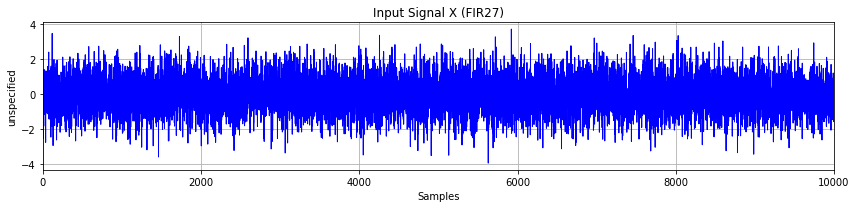

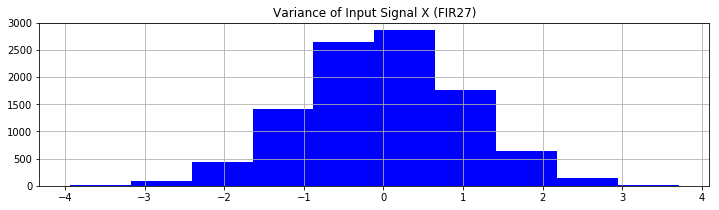

In [3]:
# load FIR data from dictionary
HfirD = importMat['System_FIR27']['D_']
HfirX = importMat['System_FIR27']['X']

# check input signal variance and plot
ts.plot(HfirX,'Input Signal X (FIR27)','lin',10000)
ts.hist(HfirX,'Variance of Input Signal X (FIR27)')
print('Input signal mean: ',np.mean(HfirX))
print('Input signal variance: ',np.var(HfirX))
#print('Eigenvalue Spread of X:', ts.eigSpread(HfirX,1000))

#### Aufgabe 1: Systemidentifikation eines FIR Systems mit variablem AWGNS


Zunächst werden wie in _Aufgabe 1_ verlangt alle Filtergewichte und Fehlerwerte je Iteration von der implementierten LMS Funktion gespeichter und somit automatisch dokumentiert. Auch lassen sich die Anzahl der Filtertaps $N$, die Schrittweite $\mu$ und die Rauschvarianz $\sigma^2$ in den Funktionsaufrufen und den print returns der Python Konsole ablesen. Der mittlere quadratische Fehler (engl. Mean-Squared Error bzw. MSE) wird hierbei im oberen Subplot als Lernkurve pro Iteration in Samples aufgetragen. 
Ein gegen 0 konvergierender Verlauf ist hier optimal, denn so zeigt sich das der Fehler zwischen dem gewünschten Signal und dem Ausgang des Filters geringer wird und das sich somit auch das Filterverhalten durch den Algorithmus verbessert.

Der untere Subplot visualisiert die jeweiligen Filtergewichte für jede Iteration. Eine Konvergenz zu einem fixen Wert für jeden Filtertap ist hier erwünscht und zeigt das das sich der Filter zunehmend auf ein Optimum zubewegt.


**Die Anzahl der Filtertaps $N$** is maßgeblich für die Komplexität des adaptiven Filters und bezeichnet die Anzahl der zur Verfügung stehenden Filterkoeffizienten bzw. Delay-Taps des FIR-Filters.

Am Rande: Laut Vorlesung muss die Anzahl der Filtertaps selbst bei komplexen oder chaotischen System nich sonderlich hoch gewählt werden. Selbst eine Anzahl von unter 10 Koeffizienten zeigt annähernd das optimale Verhalten bei der Adaption eines non-linearen quasi-chaotischen Systemverhaltens wie bspw. der *Mackey-Glass time-series* [2, p.55].)


**Die Schrittweite (des LMS) $\mu$** beeinflusst wie stark der Fehler $e[n] = d[n] - y[n]$ die Adaption für jede Iteration gewichtet. Ein großes $\mu$ erhöht dabei die Geschwindigkeit der Adaption, kann aber auch zu sehr "nervösem" Verhalten der Adaption führen und eine Konvergenz ins Fehlerminimum durch ständiges Über- und Unterschreiten der Optimalgewichtung bzw. dem zu erreichenden Minimalfehlers $J_{min}$  unmöglich machen. Eine klein gewählte Schrittweite vermeidet starkes Über - und Unterschreiten des Optimums. Die Adaption dauert aber entsprechend länger um sich in die Nähe des zu erreichenden Optimums zu bewegen.

In der Praxis werden aufgrund dieser Balance häufig adaptive Schrittweiten verwendet, welche $\mu$ je nach Tendenz und Entwicklung des MSE größer oder kleiner werden lässt. Bsp: Vergrößert sich der MSE über mehrere Iterationen - bewegt sich der Filter also möglicherweise weg vom Optimum so kann es sinnvoll sein die Schrittweite zu vergrößern. Vermindert sich der MSE hingegen über mehrere Iterationen so kann angenommen werden, dass sich das Filter auf das Optimum zubewegt und es kann eine zunehmend kleinere Schrittweite gewählt werden.


**Der Vergessensfaktor (des RLS) $\rho$** lässt sich in der vorliegenden Implementierung durch das Argument `memleak` $= -\rho + 1$ einstellen und bewegt sich auf dem Intervall $0 < \rho < 1$. Falls unverändert durch das Argument ist $\rho = 1$ und erlaubt dem RLS Algorithmus somit "kein Vergessen", bzw. werden alle vergangenen Werte gleich stark gewichtet. Mit $\rho = 1$ zeigt sich das sich der RLS ohne Vergessensfaktor und der RLS mit Vergessensfaktor identisch sind.

Laut Moschtzy [1] liegt der Wert des Vergessensfaktors typischerweise im Bereich von $0.95 < \rho < 1$, womit be- reits eine ausreichende Nachführ-Fähigkeit gegeben ist. Kleinere Werte für den Vergessensfaktor können zu Stabilitätsproblemen bei der Adaption führen, da nie ausreichend Information über den Prozess behalten wird. Dies gilt besonders bei einer nichtstationären Umgebung, wie sich in der Simulation des Systemwechsels zeigen wird.


**Die Rauschvarianz $\sigma^2$** beeinflusst die Standardabweichung des AWGNS (Additive White Gaussian Noise), welches dem in der Simulation übertragenen Signal $d[k]$ durch die Messstrecke aufaddiert wird. Die Varianz beeinflusst hiermit die "Stärke" des Rauschens indem durch große Werte auch große, zufällige Amplitudenwerte möglich sind. Kleine Werte für $\sigma^2$ halten also das Signal-Rausch-Verhältnis groß (SNR groß) und große Werte für $\sigma^2$ erwirken im Resultat ein geringeres Signal-Rausch-Verhältnis. Große Werte "verrauschen" das Zielsignal also stärker. Dies entspricht in unserer Simulation einer schlechteren Übertragunggstrecke.
Mit dem hinzufügen des AWGNS können wir die Stabilität des Filters gegenüber Rauschen prüfen und somit ermitteln welche Algorithmen sich für ein solches Problem in der Übertragungsstrecke besser eignen und wie schlecht die Verbindung dabei werden darf um trotzdem zufriedenstellende Ergebnisse zu erhalten.

Da es sich bei AWGNS um einen stationären, stochastischen Prozess handelt kann die Anfälligkeit der adaptiven Filter hiermit zunächst nur hinsichtlicher eines solchen Störfaktors untersucht werden.


**Die Lernkurve** trägt den mittleren quadratischen Fehler zwischen dem Zielwert $d[n]$ und dem Ausgang des Filters $y[n]$ für jede Iteration $n$ in Samples auf, also: $(e[n])^2 = (d[n] - y[n])^2 = MSE[n]$. Wird der MSE über Zeit bzw. für jedes fortlaufende Sample kleiner so lässt sich das bei gleichbleibenden Randbedingungen als Verbesserung der Adaption des Filters interpretieren.

In der Darstellung der Plots wird die Lernkurve mit einem gleitenden Mittelwert über 30 Samples (default) gemittelt. Dies entsprich annähernd der Beschreibung von Moschytz [1, p.153/154], welcher für seine Darstellung mehrere Durchläufe mittelt und anschließend ein Exponentielles Fenster zur Mittelung  wählt (Die Größe des Fenster ist dabei nicht bekannt).

Der MSE kann auch in Dezibel der Form $MSEdB = 10 \cdot log10(\frac{e_n}{e_0})$ aufgetragen werden. Die Einheit *Bel* dient immer zur Kennzeichnung des dekadischen Logarithmus des Verhältnisses zweier gleichartiger Energie- bzw. Leistungsgrößen. In meiner hier vorliegenden Implementierung (`ts.errorPlot`) wird analog zu Moschytz [1, p.153/154] die Bezügsgröße $e_0$ als der erste vorliegende Fehler $e[0]$ gewählt. Somit bezieht sich die Verbesserung in Dezibel im Verhältnis immer auf den ersten gemessenen Fehler des aktuellen Durchlaufs. Eine Angabe von bspw. $-13\,dB$ bezieht sich also nicht auf die Verbesserung des SNR im Signal sondern jediglich auf die Verbesserung gegenüber dem Fehler des ersten Iteration $n$.

Weiter ist zu bemerken, das zwei als _durchschnittlich_ angegebene Fehler im Plot (oben rechts) angegeben sind. Der Wert `avgOpt(E)` bezieht sich hier auf den Restfehler nach der Konvergenz des Algorithmus. Der zweite Wert `avgAll(E)` bildet den Durchschnitt über den gesamten Signalverlauf. Da ich primär an dem Restfehler interessiert war, ist dieser Wert meist in den Plots gemeint - falls nicht anders angegeben.



* LMS: N = 1, mu = 0.001, w = [0.7019781]
       with AWGNS variance = 0.001, SNR = 27.71 dB


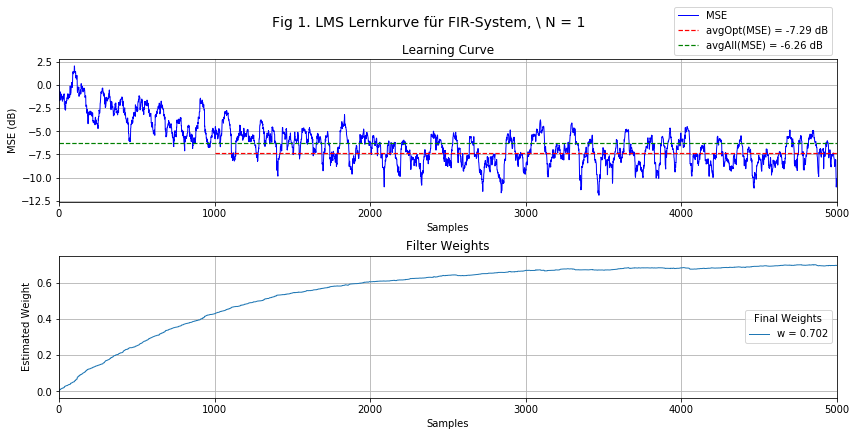

In [4]:
# FIR LMS study
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# Length of displayed plot
plotLen = 5000

# N = 1
N, mu, var = 1, 0.001, 0.001
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 1. LMS Lernkurve für FIR-System, \ N = '\
             +str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 1.** 
Um die Komplexität des (unbekannten) FIR-Systems aus der Aufgabe mit $N = 5$ zu erreichen sind, wie im ersten Plot oben zu sehen $N = 1$ Taps nicht hinreichend. Obwohl hier eine nahezu optimale Übertragungsstrecke mit kaum Rauschen vorliegt ($\sigma_1^2 = 0.001$) und die Schrittweite relativ gering gewählt wurde wird das Rauschen bei einem Signal-Rausch reellen Verhältnis von $27.8 \,dB$ im Verhältnis zum Anfangsfehler durschnittlich um etwa $-7 \,dB$ reduziert.

Bemerkung: Eine Rauschtoleranz müsste beim Entwurf des Filtersystems vorher definiert werden um eine Eignung des zu prüfenden Systems zu definieren. Ansonsten verbleibt nur eine qualitative Auswertung dieses Werts.

* LMS: N = 2, mu = 0.01, w = [0.69758166 0.08318694]
       with AWGNS variance = 0.01, SNR = 17.79 dB


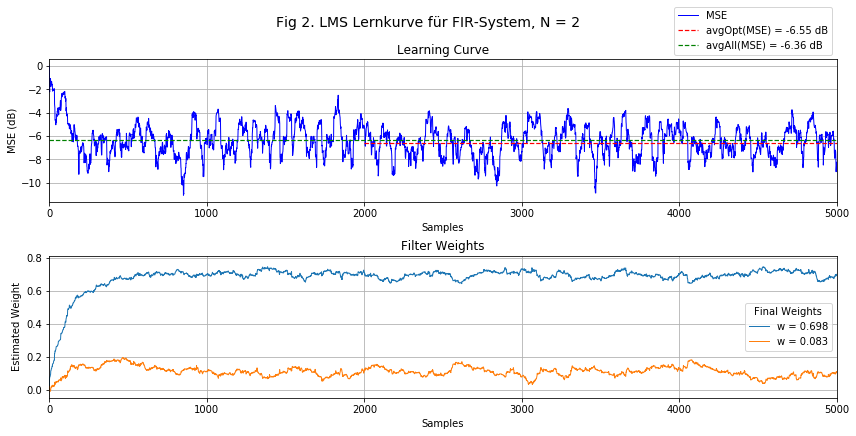

In [5]:
# N = 2
N, mu, var = 2, 0.01, 0.01
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 2. LMS Lernkurve für FIR-System, N = '\
             +str(N), style='log')
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 2.** 
Eine ähnlich gute Rauschunterdrückung zu *Fig 1* bei $N = 1$ mit etwa $-6.5 \,dB$ im Verhältnis zum ersten Fehlerwert erfolgt trotz der zehnfachen Varianz ($\sigma_2^2 = 0.01 = 10 \cdot \sigma_1^2$) des beigemischten Rauschens bei Verdopplung der Anzahl der Filtertaps auf $N = 2$.

* LMS: N = 5, mu = 0.01, w = [ 0.69519356  0.09145897  0.01682561  0.19001267 -0.25452331]
       with AWGNS variance = 0.1, SNR = 7.75 dB
* LMS: N = 5, mu = 0.1, w = [ 0.7   0.1  -0.03  0.18 -0.24]
       with AWGNS variance = 0, SNR = 3074.36 dB
* LMS: N = 5, mu = 0.001, w = [ 0.69729648  0.06397129 -0.02163753  0.22060586 -0.24362931]
       with AWGNS variance = 1, SNR = -2.23 dB


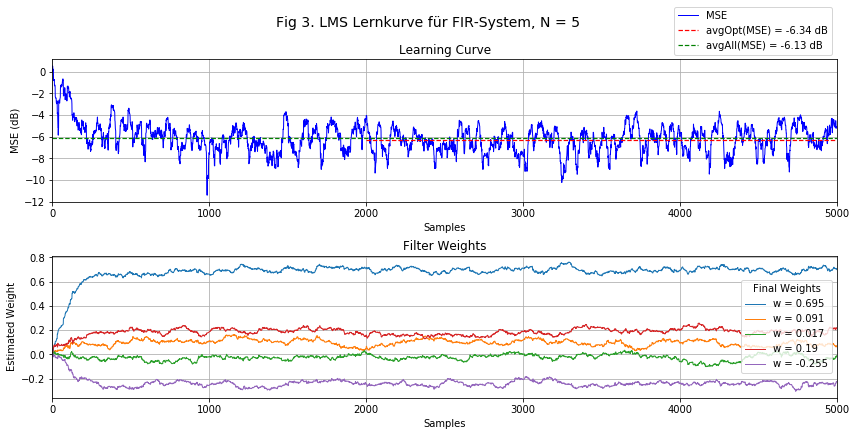

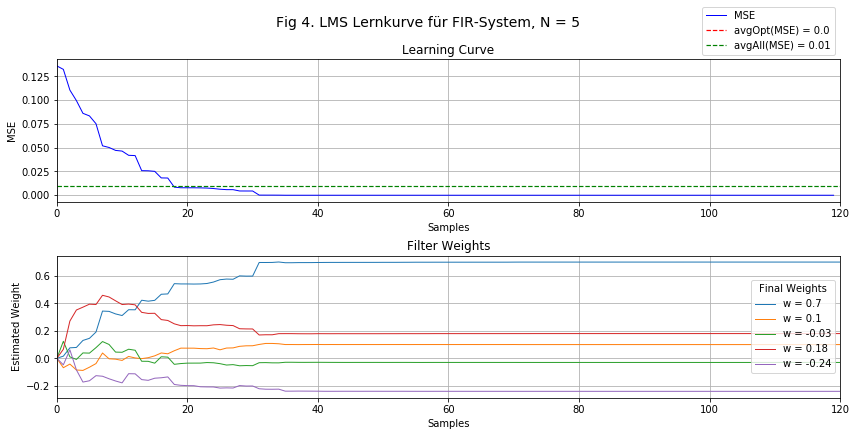

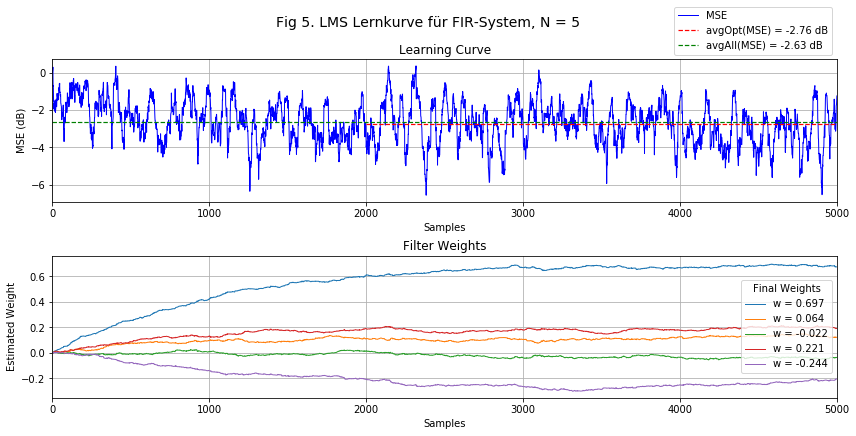

In [6]:
# N = 5
N, mu, var = 5, 0.01, 0.1
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 3. LMS Lernkurve für FIR-System, N = '\
             +str(N), style='log')
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

N, mu, var = 5, 0.1, 0
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, 120, 'Fig 4. LMS Lernkurve für FIR-System, N = '\
             +str(N), style='lin')
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

N, mu, var = 5, 0.001, 1
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 5. LMS Lernkurve für FIR-System, N = '\
             +str(N), style='log')
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 3.** Mit $N = 5$ erhält man die selbe Rauschunterdrückung von etwa $-7\,dB$ selbst bei einer weiteren Verzehnfachung der Rauschvarianz im Vergleich zu den Ausgangsbedingungen in *Fig 1* und *Fig 2*.

**Fig 4.** Exemplarisch wird hier eine sehr große Schrittweite von $\mu = 0.1$ *ohne* AWGNS gewählt um zu demonstrieren, dass der LMS Algorithmus unter Optimalbedingungen (kein Rauschen in der Übertragungsstrecke) sehr schnell die exakten, optimale Gewichtung mit $h_0 = 0.7, h_1 = 0.1, h_2 = -0.03, h_3 = 0.18, h_4 = -0.24$ adaptieren kann. Dies entspricht exakt den Werten des eigentlich unbekannten Systems (siehe oben in der Aufgabenstellung).

**Fig 5.** Erhöht man die Varianz des Rauschens auf $\sigma^2 = 1$ so stellt sich trotz $N = 5$ und einer geringen Schrittweite keine sonderliche Fehlerminimierung jenseits von $-2\,dB$ ein. Eine Betrachtung von höherer Rauschvarianz, bspw. $\sigma^2 = 10$ ist an dieser Stelle also hinfällig hinsichtlich einem brauchbaren Ergebnis.

## Aufgabe 1: FIR Systemidentifikation via RLS Algorithmus

* RLS: N = 1, w = [0.70028888]
       with AWGNS variance = 0.001, SNR = 27.76 dB


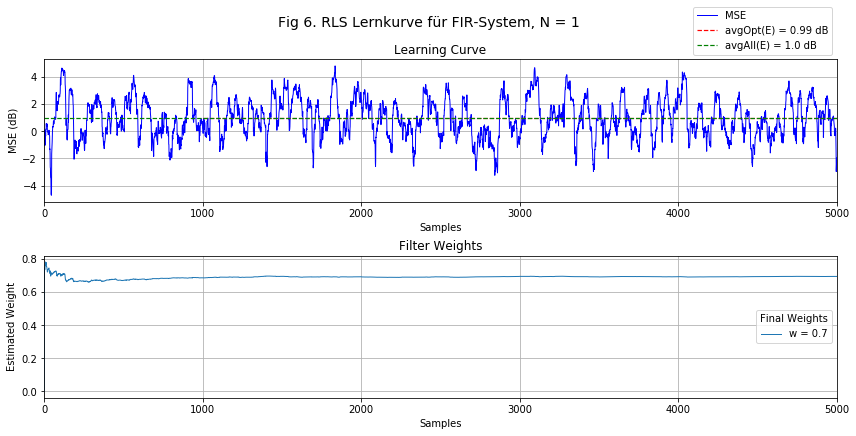

In [17]:
# FIR RLS study
# N  = 1, 2, 5
# var = 0.001, 0.1, 1, 10

# Style of displayed plot
plotLen = 5000

# N = 1
N, var = 1, 0.001
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 6. RLS Lernkurve für FIR-System, N = '\
             +str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 6.** Analog zur Betrachtung des LMS Algorithmus wurde hier zunächst für $N = 1$ das AWGNS möglichst gering gehalten. Eine Verbesserung durch die Adaption des RLS ist schwer festzustellen, denn der Fehler bleibt auch über die gesamte Signallänge etwa gleich groß auch wenn sich die Adaption des Filterkoeffizienten zu $h_0 = 0.7$ vergleichsweise schnell einstellt und somit bis auf minimale Abweichungen auf den selben Wert konvergiert wie der LMS Algorithmus.

* RLS: N = 2, w = [0.6987517 0.1050955]
       with AWGNS variance = 0.001, SNR = 27.87 dB


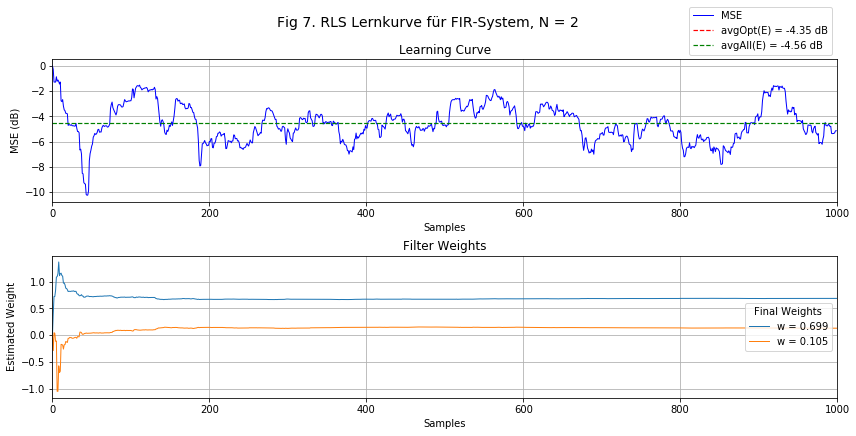

In [18]:
# Style of displayed plot
plotLen = 1000

# N = 2
N, var = 2, 0.001
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 7. RLS Lernkurve für FIR-System, N = '\
             +str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 7.** Mit der Erhöhung der Anzahl der Filterkoeffizienten auf $N = 2$ und gleichbleibender Varianz des AWGNS stellt sich eine durchschnittliche Fehlerminimierung von etwa $-4\,dB$ ein. Im Vergleich hierzu erzielte der LMS konvergieren hierfür die Filterkoeffizienten deutlich schneller.

* RLS: N = 5, w = [ 0.70030212  0.10060392 -0.03119163  0.17892721 -0.2387291 ]
       with AWGNS variance = 0.01, SNR = 17.79 dB
* RLS: N = 5, w = [ 0.70244702  0.10314245 -0.02951401  0.18446172 -0.2398641 ]
       with AWGNS variance = 0.1, SNR = 7.85 dB
* RLS: N = 5, w = [ 0.69538254  0.07757242 -0.04288757  0.16613658 -0.25870468]
       with AWGNS variance = 10, SNR = -12.18 dB


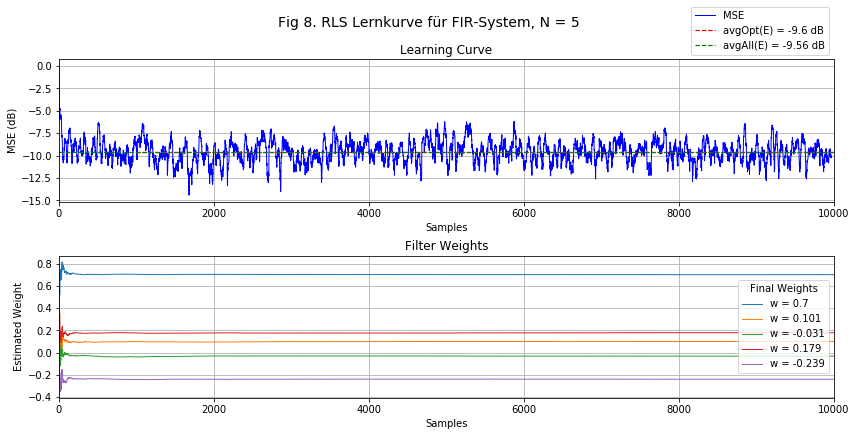

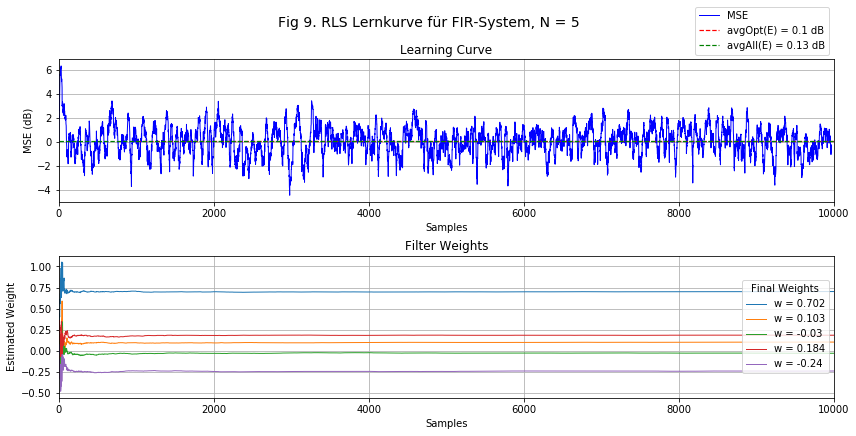

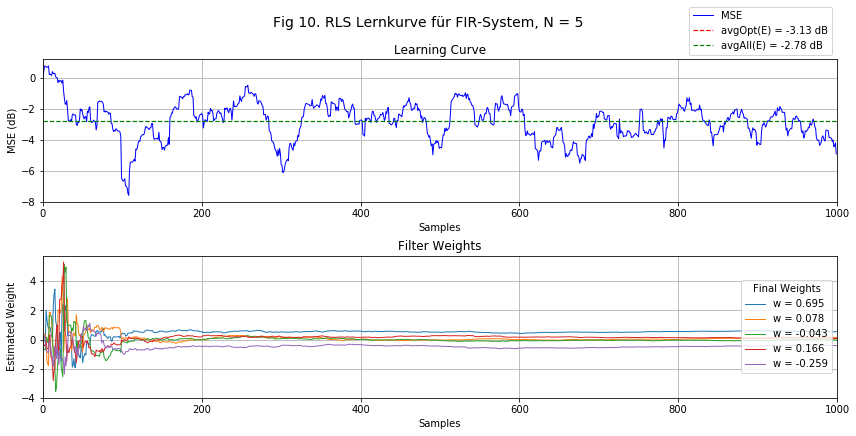

In [21]:
# Style of displayed plot
plotLen = 10000

# N = 5
N, var = 5, 0.01
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 8. RLS Lernkurve für FIR-System, N = '\
             +str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

N, var = 5, 0.1
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 9. RLS Lernkurve für FIR-System, N = '\
             +str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

N, var = 5, 10
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, 1000, 'Fig 10. RLS Lernkurve für FIR-System, N = '\
             +str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 8.** Nach Erhöhung der Filterkoeffizienten auf $N = 5$ stellt sich bei einer Rauschvarianz von $\sigma^2 = 0.01$ eine Rauschunterdrückung von etwa $-11\,dB$ im Verhältnis zum ersten Fehler ein.

**Fig 9.** Auch nach Erhöhung der Rauschvarianz auf $\sigma^2 = 0.1$ ist noch eine durchschnittliche Rauschunterdrückung von etwa $-5\,dB$ zu verzeichnen. Dies ist ein vergleichbares Ergebniss mit dem LMS - doch stellt sich hier die Adaption deutlich schneller ein.

**Fig 10.** Selbst nach einer Erhöhung der Rauschvarianz auf $\sigma^2 = 10$ ist noch eine durchschnittliche Fehlerminimierung von etwa $-1\,dB$ bis $-5\,dB$ zu verzeichnen. Dieses Interval hängt wie bereits beschrieben im Logarithmus von dem Bezugswert - also in diesem Fall von dem ersten Fehlerwert ab. Auch die Adaption stellt sich hier erstaunlich schnell ein im Vergelich zum Verlauf der Lernkurve des LMS.

#### Zwischenfazit FIR Identifikation
Die Adaption des RLS Algorithmus verläuft deutlich schneller und erzielt ähnlich gute Ergebnisse wie der LMS Algorithmus bei der Rauschunterdrückung bzw. Identifikation des linearen FIR-Systems mit AWGNS gestörter Übertragungsstrecke. Wichtig ist im Allgemeinen bei beiden Algorithmen eine ausreichende Anzahl von Filtertaps $N$ und eine sinnvolle Größe für die Schrittweite $\mu$ des LMS Algorithmus. Eine Betrachtung des "Forgetting Factors" des RLS Algorithmus musste bisher nicht getätigt werden, da es sich bei dem beigemischten AWGNS um einen stationären stochastischen Prozess handelt.

## Aufgabe 2: IIR Systemidentifikation
Für das IIR-Filter: Stelle die gleichen Untersuchungen wie beim FIR-Filter an.

Bemerkung: Da weder RLS noch LMS im Vergleich zu dem vorliegenden IIR-System einen rekursiven Anteil besitzen, ist zu erwarten das die Adaption mehr als nur $N = 2$ Filterkoeffizienten brauchen wird um das IIR-System hinreichend approximieren zu können.

Input signal mean:  -0.018132438065400953
Input signal variance:  1.0270666666078994


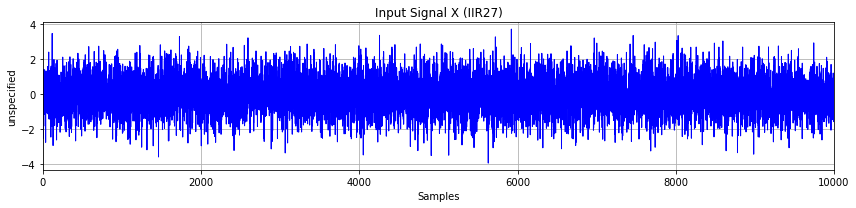

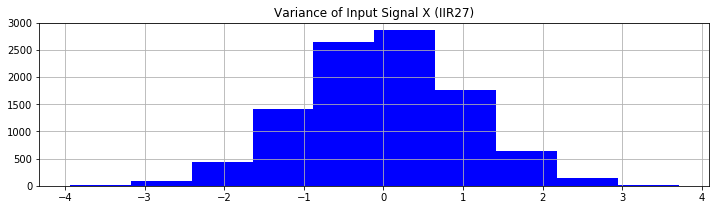

In [22]:
# load IIR data from dictionary
HiirD = importMat['System_IIR27']['D_']
HiirX = importMat['System_IIR27']['X']

# check input signal variance and plot
ts.plot(HiirX,'Input Signal X (IIR27)','lin',10000)
ts.hist(HiirX,'Variance of Input Signal X (IIR27)')
print('Input signal mean: ',np.mean(HfirX))
print('Input signal variance: ',np.var(HfirX))
#print('Eigenvalue Spread of X:', ts.eigSpread(HiirX,1000))

* LMS: N = 1, mu = 0.001, w = [1.02518668]
       with AWGNS variance = 0.001, SNR = 34.56 dB
* RLS: N = 1, w = [1.02682277]
       with AWGNS variance = 0.001, SNR = 34.59 dB


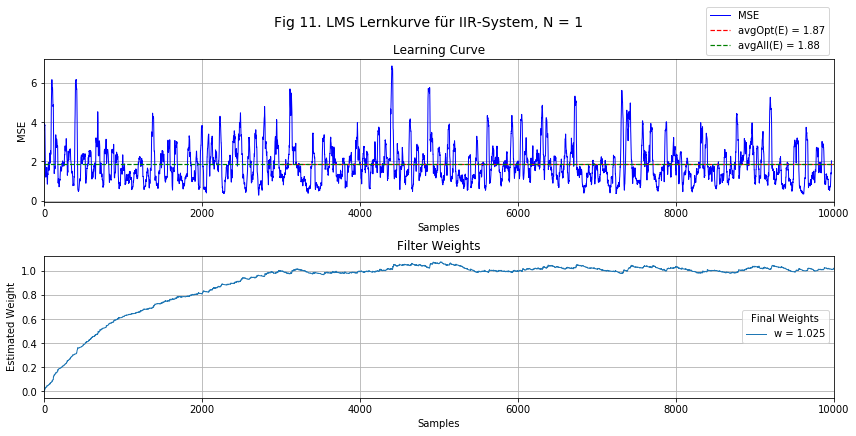

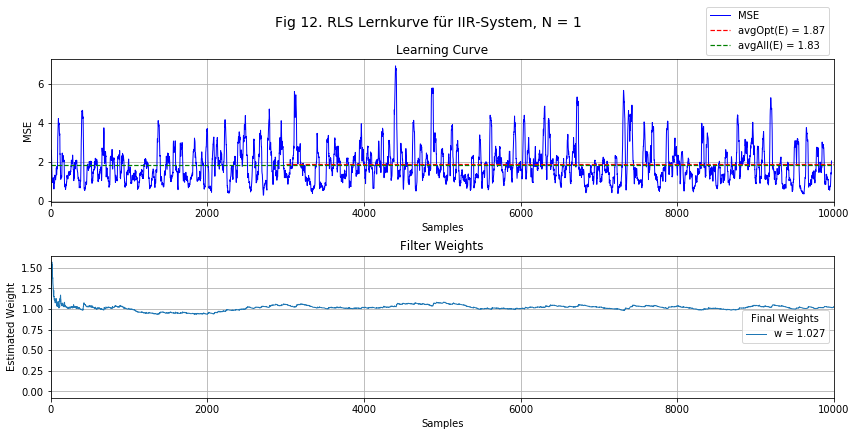

In [26]:
# IIR LMS/RLS study
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# Length of displayed plot
plotLen =10000
plotStyle = 'lin'

# LMS, N = 1
N, mu, var = 1, 0.001, 0.001
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 11. LMS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=3000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 1
N, var, forget = 1, 0.001, 0.001
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.rlsAlg(N, HiirX, HiirDn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 12. RLS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=3000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 11 & 12.** 
Sowohl der LMS-Algorithmus als auch der RLS-Algorithmus erzielen anhand des IIR-Systems bei einer Rauschvarianz von $\sigma^2 = 0.001$ eine Fehlerminimierung von etwa $-2\,dB$.

Es ist zu bemerken das hierfür aber eine relativ lange Adaptionszeit (~4000 Samples) für den LMS in kauf genommen wird. Der RLS-Algorithmus konvergiert hierbei deutlich schneller und erzielt daher auch früher bessere Ergebnisse.
Eine Approximation des IIR-Systems mit $N = 1$ ist somit nicht sinnvoll.

* LMS: N = 2, mu = 0.001, w = [0.99880471 0.84095599]
       with AWGNS variance = 0.001, SNR = 34.66 dB
* RLS: N = 2, w = [1.00155923 0.8330344 ]
       with AWGNS variance = 0.001, SNR = 34.63 dB


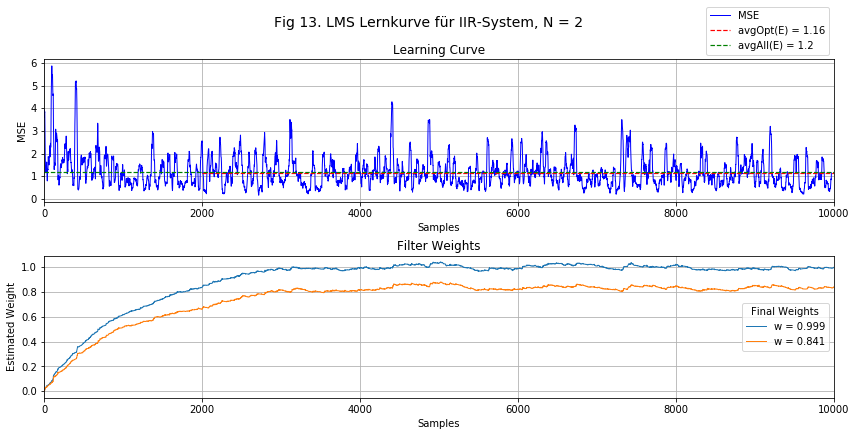

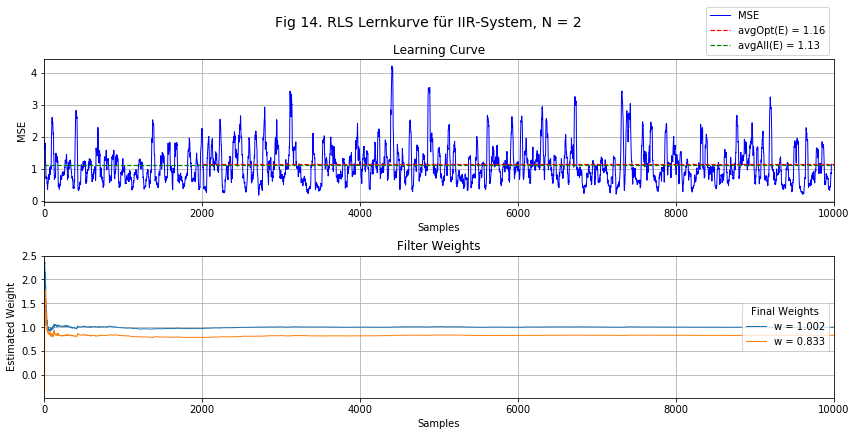

In [31]:
# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'

# LMS, N = 2
N, mu, var = 2, 0.001, 0.001
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 13. LMS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=2000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 2
N, var, forget = 2, 0.001, 0.0
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.rlsAlg(N, HiirX, HiirDn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 14. RLS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=2000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 13 & 14.** 
Bei Erhöhung der verfügbaren Filterkoeffizienten auf $N = 2$ bei gleichbleibender Rauschvarianz erzielen auch hier beide Algorithmen vergleichbare Ergebnisse mit einem durchschnittlichen Fehler von $1.16$. Da sich der zugrundeliegende Prozess nicht verändert bringt eine Verkleinerung von $\rho < 1$ keinen Unterschied und führt bei zu kleinen Werten zu Instabilität und schlechteren Ergebnissen.

* LMS: N = 5, mu = 0.001, w = [0.99685073 0.81061186 0.63090174 0.49931982 0.41243533]
       with AWGNS variance = 0.1, SNR = 14.65 dB
* RLS: N = 5, w = [1.00797995 0.81727358 0.64407373 0.5047961  0.39316777]
       with AWGNS variance = 0.1, SNR = 14.61 dB


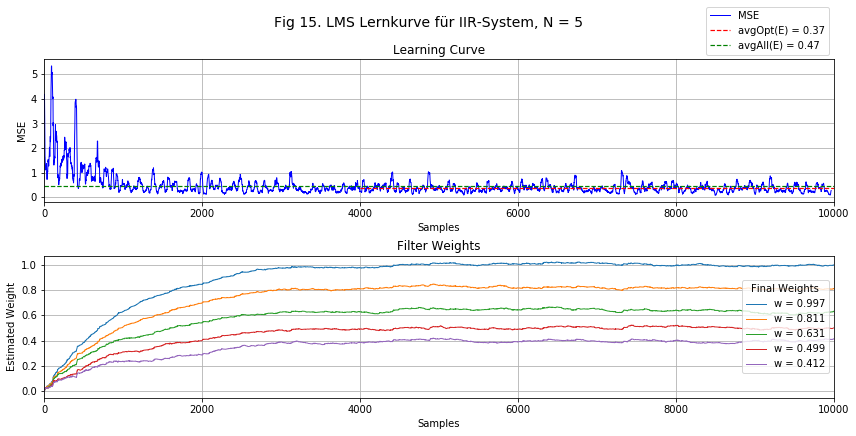

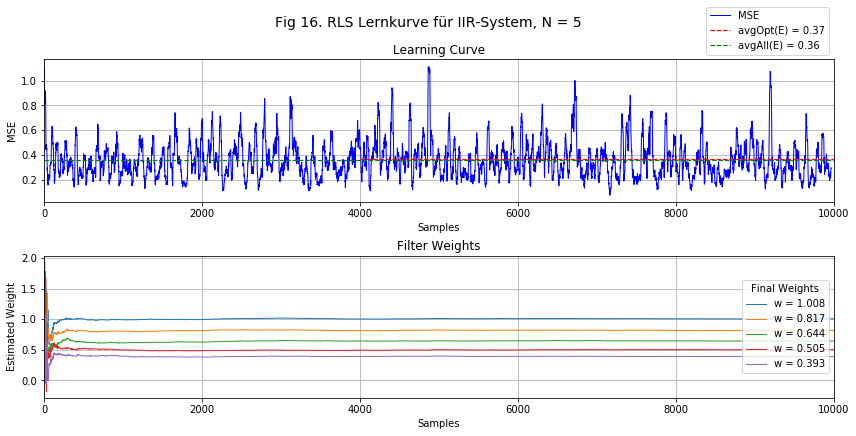

In [34]:
# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'
avgFrom = 4000

# LMS, N = 5
N, mu, var = 5, 0.001, 0.1
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 15. LMS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=avgFrom)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 5
N, var, forget = 5, 0.1, 0.0
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.rlsAlg(N, HiirX, HiirDn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 16. RLS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=avgFrom)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 15 & 16.** 
Nach Erhöhung der Filterkoeffizienten auf $N = 5$ und der Rauschvarianz des AWGNS auf $\sigma^2 = 0.1$ erzielen sowohl der RLS als auch der LMS Algorithmus wieder ähnliche Ergebnisse. Durch die schnellere Adaption des RLS Algorithmus wird der Fehler `avgAll(MSE)` über die gesamte Länge der Lernkurve mit $0.36$ um $0.11$ besser im Vergleich zum RLS Algorithmus, welcher bei $0.47$ liegt.

#### Zu Aufgabe 1 & 2: Systemidentifikation eines FIR/IIR-Systems mit variablem AWGNS via LMS und RLS Algorithmus

Im Allgemeine unterscheiden sich der LMS- und der RLS-Algorithmus anhand ihrer Konvergenzzeit, der resultierenden Fehlerminimierung, dem Rechenaufwand und eignen sich daher jeweils für spezifische Anwendungsfälle.

Ein Hauptmerkmal des LMS Algorithmus liegt darin, dass es sich um einen Markov Prozess handelt. Der LMS besitzt einen Momentanzustand, speichert aber keine vergangenen Daten im laufenden Vorgang des Adaptionsprozesses. Diese Eigenschaft ist auch gut für zeitlich veränderliche Systemeigenschaften geeignet, denn vergangene Information würde sonst zu fehlerhafter Information über die momentanen Werte führen. Diese Eigenschaft wird sich sicher in der folgenden Simulation des Systemwechsels (Aufgabe 3) besonders zeigen. Im Austausch für dieses Verhalten pendeln sich die Werte des Filters trotz zu beobachtender Konvergenz nie ganz ein, sondern kreisen immer um das Optimum. In dieser Hinsicht ist der RLS "stabiler" in der Konvergenz der Filterkoeffizienten (Bemerkung: Mit "Stabilität" ist hier nicht das Verhalten des Filters gemeint, denn ein FIR-Filter ist immer stabil da er keinen rekursiven Anteil besitzt). Dieser Eigenschaft des LMS kann durch einer variablen bzw. adaptiven Schrittweite $\mu$ beholfen werden. So könnte sich die Schrittweite reduzieren, falls der Fehler über mehrere Iterationen kleiner wird. Analog hierzu könnte die Schrittweite vergrößert werden, falls der Fehler sicher über mehrere Interationen wieder vergrößert.

Der RLS-Algorithmus hingegen verwendet außer den Momentanwerten auch alle vergangenen Informationen zur Optimierung der Adaption. Dies kann im Gegenteil zum LMS zu fehlerhaftem Verhalten bei zeitlich veränderlichen Signalen führen. Diese Schwachstelle kann vermindert werden indem ein sogenannter Vergessensfaktor im RLS Algorithmus eingeführt wird, welcher vergangene Werte bis hin zum _"absoluten Vergessen"_ weniger stark gewichtet. Diese Funktionalität war für die bisherigen Untersuchungen nicht notwendig, da sich laut der Vorgabe die Größen der zugrundeliegenden stationären stochastischen Prozesse nicht ändern. Auch experimentelle Ergebnisse unterstreichen diese These, denn eine Justierung des Vergessensfaktors $\rho$ brachte keine merkliche Verbesserung im Adaptionsverhalten.

Der RLS Algorithmus ist außerdem rechenintensiver gegenüber dem LMS Algorithmus. Im Austausch für diese Schwächen konvergiert der RLS Algorithmus deutlich schneller und bleibt bei einmaliger Konvergenz sehr stabil. Bei stochastisch stationären Prozessen liefert der RLS-Algorithmus stabile Ergebnisse und ist bei außreichend verfügbarer Rechenleistung zu bevorzugen. Dies zeigt sich auch in der Verbesserung des Signal-Rausch-Verhältnis, denn der RLS führt im Schnitt bei der selben Rauschvarianz zu besseren Ergebnissen durch eine bessere Rauschunterdrückung bzw. geringerer Rauschanfälligkeit bei der Systemidentifikation. Durch die beschleunigte Adaption des RLS Algorithmus ist außerdem der resultierende Gesamtfehler kleiner, was in einem Anwendungsfall schneller zu einem optimalen Ergebnissen führen würde.

<!---
Im Allgemeinen ist es bekannt das der RLS-Algorithmus besser für deterministische Prozesse geeignet ist und der LMS-Algorithmus für stochastische Prozesse. Da in dieser Simulation primär die Adaption für stochastische Prozesse (AWGNS) analysiert wird ist auch nicht zu erwarten, dass der RLS-Algorithmus im Vergleich zum LMS besser abschneidet.
-->

Zu beachten ist außerdem das die Fehlerminimierung durch den RLS-Algorithmus deutlich früher erfolgt als bei dem LMS-Algorithmus. Dies ist u.a. an den durchschnittlichen Fehlerwerten `avgOpt(E)` und `avgAll(E)` zu sehen. Im folgenden (ab Aufgabe 3) eignet sich die Bildung dieser beiden Fehlerwerte auch um den durchschnittlichen Fehler vor- und nach dem Systemwechsel, sowie über den gesamten Verlauf zu ermitteln. Die qualitative Bezeichnung "Opt" und "All" sind hier aber nicht mehr zutreffend.

<!---
RLS vs LMS Performance: https://dsp.stackexchange.com/a/8188/32224
RLS, LMS and Wiender: https://dsp.stackexchange.com/a/50366/32224
-->


## Aufgabe 3
Es soll nun der Einfluss eines plötzlichen Systemwechsels untersucht werden. Dazu werden die Filterkoeffizienten des erzeugenden Systems nach 5000 Iterationen geändert. Lade nun die Datei Systemwechsel_FIR.mat und Systemwechsel_IIR.mat. Sie enthalten die gleichen Signale wie schon System_FIR.mat und System_IIR.mat. Zeige wiederum das Lernverhalten für verschiedene Störeinflüsse, Lernalgorithmen und Fitlerordungen. Erläutere auch hieran das Adaptionsverhalten. 

Welches Verfahren eignet sich unter welchen Bedingungen am besten?

Input signal 1 mean:  -0.010424975412711203
Input signal 1 variance:  0.5975436877185286
Input signal 2 mean:  -0.035691786431926054
Input signal 2 variance:  1.2498135548043237


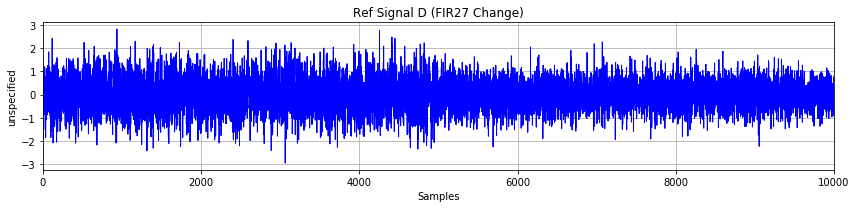

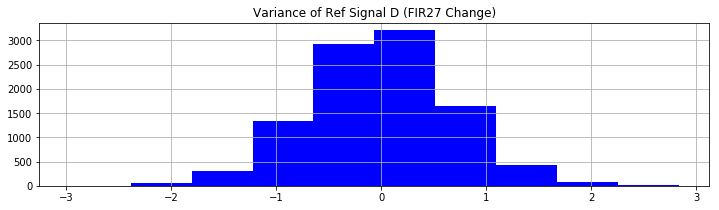

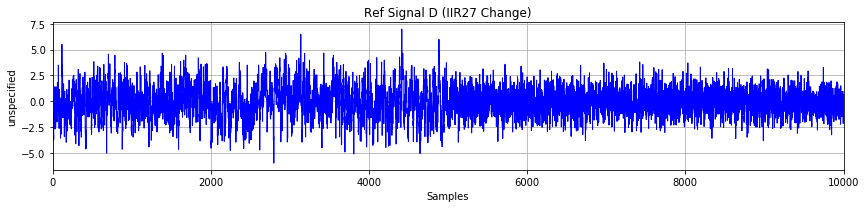

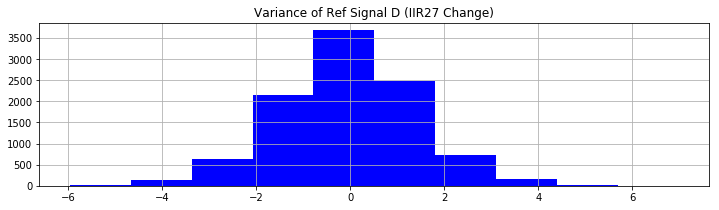

In [35]:
# load FIR data from dictionary
HfirDc = importMat['Systemwechsel_FIR27']['D_']
HfirXc = importMat['Systemwechsel_FIR27']['X']
HiirDc = importMat['Systemwechsel_IIR27']['D_']
HiirXc = importMat['Systemwechsel_IIR27']['X']

# check input signal 1 variance and plot
ts.plot(HfirDc,'Ref Signal D (FIR27 Change)','lin',10000)
ts.hist(HfirDc,'Variance of Ref Signal D (FIR27 Change)')
print('Input signal 1 mean: ',np.mean(HfirDc[0,0:5000]))
print('Input signal 1 variance: ',np.var(HfirDc[0,0:5000]))

# check input signal 2
ts.plot(HiirDc,'Ref Signal D (IIR27 Change)','lin',10000)
ts.hist(HiirDc,'Variance of Ref Signal D (IIR27 Change)')
print('Input signal 2 mean: ',np.mean(HiirDc[0,5000:]))
print('Input signal 2 variance: ',np.var(HiirDc[0,5000:]))

**Plots oben:** Klar in den Plots oben zu sehen ist der Systemwechsel bei der Hälfte (ab Sample 5000) des Signals.

* LMS: N = 5, mu = 0.01, w = [1.00927581 0.39260851 0.14115679 0.04428642 0.03658712]
       with AWGNS variance = 0.1, SNR = 13.09 dB
* RLS: N = 5, w = [1.05415355 0.36977482 0.11437001 0.00931197 0.05286359]
       with AWGNS variance = 0.1, SNR = 13.22 dB


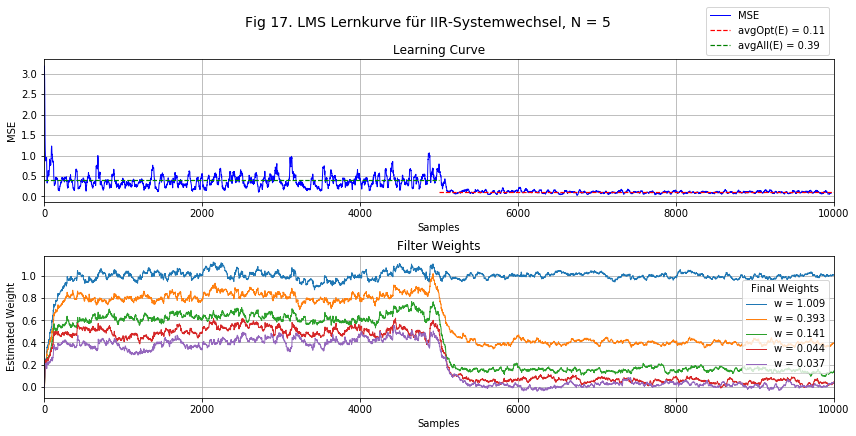

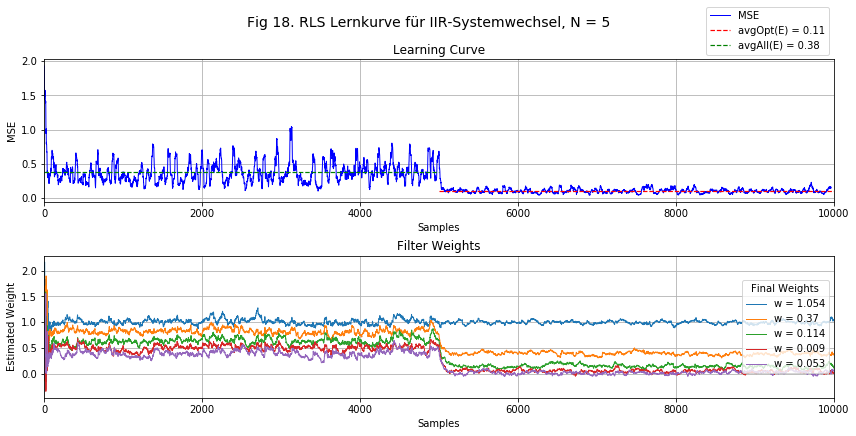

In [37]:
# IIR LMS/RLS study: System change
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10
plotLen = 10000
plotStyle = 'lin'

# LMS, N = 5
N, mu, var = 5, 0.01, 0.1
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirXc, HiirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 17. LMS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 5
N, var, forget = 5, 0.1, 0.02
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HiirXc, HiirDcn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 18. RLS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

Bemerkung: Es wird zunächst der Systemwechsel des IIR-Systems untersucht.

**Fig 17 & 18.** 
Im Vergleich des RLS- und LMS-Algorithmus im Plot oben ist sowohl die laufende Adaption des LMS als auch die Auswirkung des Vergessensfaktors gut zu erkennen, denn die Filterkoeffizienten konvergieren nach dem Systemwechsel relativ schnell auf ein neues Optimum. Sowohl die sich einstellenden Filterkoeffizienten als auch der Restfehler ähneln sich unter den obigen Einstellungen sehr.

Um also ähnlich gute Ergebnisse zum LMS durch den RLS Algorithmus erzielen zu können muss das Argument `memleak` mit $\rho = 1 -$ `memleak` und $0 < \rho < 1$ passend justiert werden. Analog hierzu muss natürlich auch die Learning Rate $\mu$ des LMS angepasst werden.

* LMS: N = 2, mu = 0.01, w = [0.99940598 0.41226644]
       with AWGNS variance = 0.001, SNR = 33.16 dB
* RLS: N = 2, w = [1.00415526 0.41706533]
       with AWGNS variance = 0.001, SNR = 33.17 dB


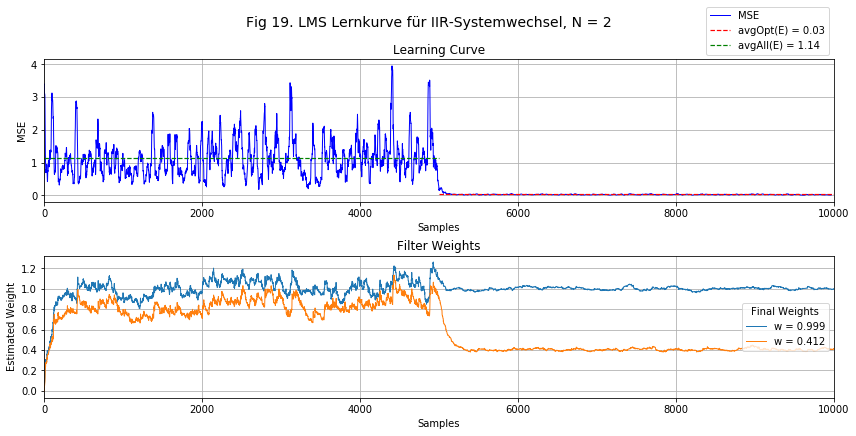

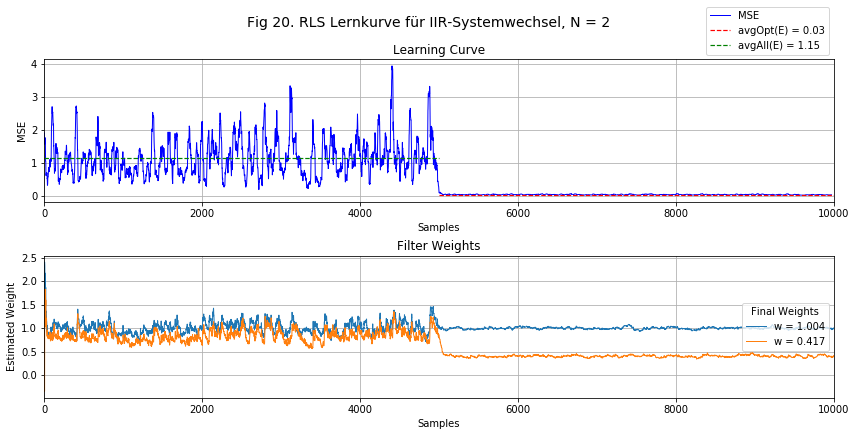

In [44]:
plotStyle = 'lin'

# LMS, N = 2
N, mu, var = 2, 0.01, 0.001
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirXc, HiirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 19. LMS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 2
N, var, forget = 2, 0.001, 0.03
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HiirXc, HiirDcn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 20. RLS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 19 & 20.**
Ähnlich zur Verwendung von $N = 5$ Filterkoeffizienten sind bei $N = 2$ und passender Justierung von $\mu$ und $\rho$ ähnliche Ergebnisse zu erzielen.

* LMS: N = 1, mu = 0.01, w = [1.01864878]
       with AWGNS variance = 0.01, SNR = 23.18 dB
* RLS: N = 1, w = [1.02997786]
       with AWGNS variance = 0.01, SNR = 23.19 dB


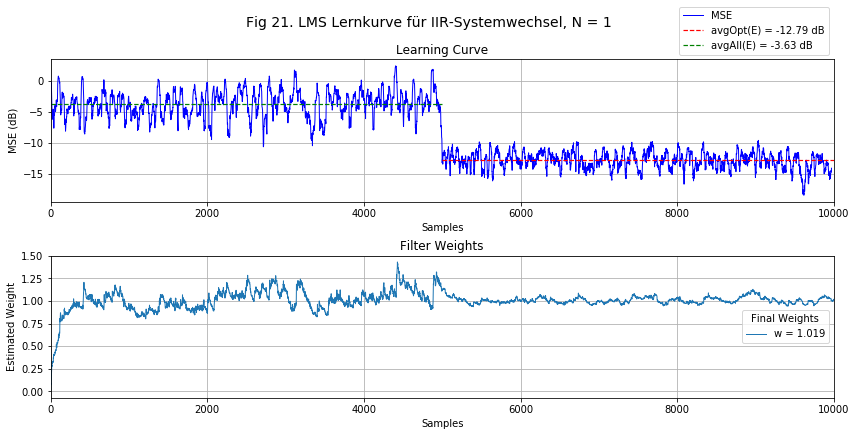

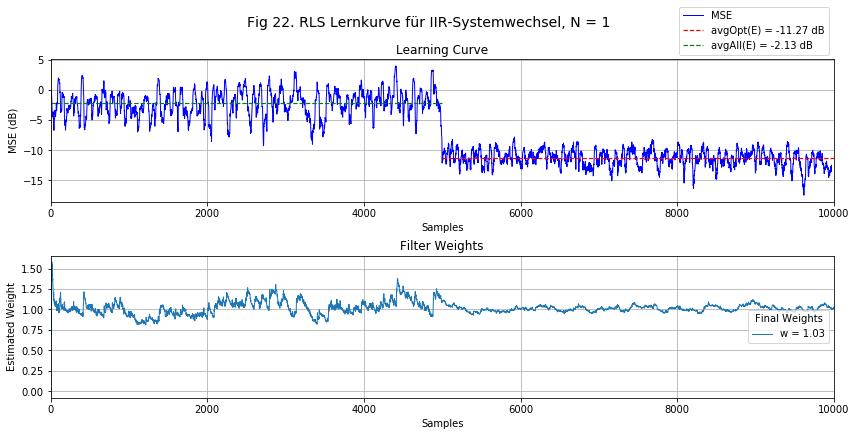

In [46]:
# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'

# LMS, N = 1
N, mu, var = 1, 0.01, 0.01
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirXc, HiirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 21. LMS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style='log',avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 1
N, var, forget = 1, 0.01, 0.01
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HiirXc, HiirDcn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 22. RLS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style='log',avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 21 & 22.**
Unter Verwendung von nur einem Filterkoeffizienten stellen sich ähnliche Ergebnisse wie zuvor beobachtet ein. Interessant ist hier, das die Adaption beider Algorithmen nach dem Systemwechsel keine deutliche Veränderung für den einzelnen Filterkoeffizienten hervorruft. Die Lernkurven des LMS und RLS ähneln sich bei $N = 1$ vergleichsweise sehr und zeigen einen ähnlichen Verlauf des MSE.

* LMS: N = 5, mu = 0.01, w = [ 0.39997414 -0.01434487  0.2915051  -0.17723171 -0.19885174]
       with AWGNS variance = 0.01, SNR = 16.69 dB
* RLS: N = 5, w = [ 0.38970375  0.00651234  0.28563667 -0.16213313 -0.19730398]
       with AWGNS variance = 0.01, SNR = 16.74 dB


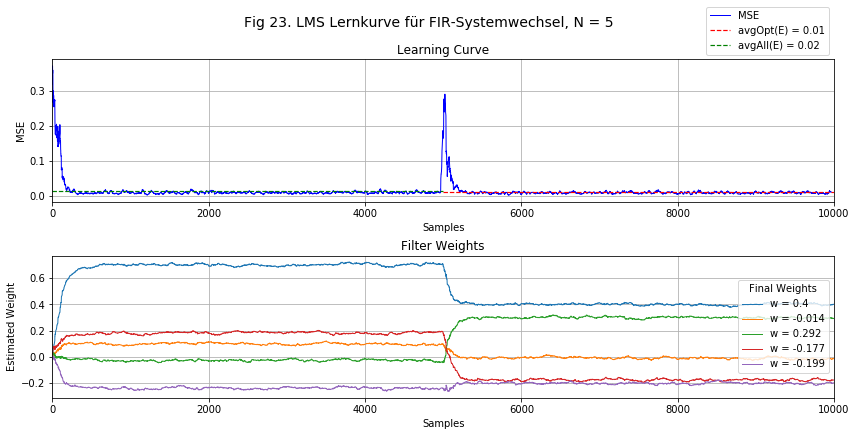

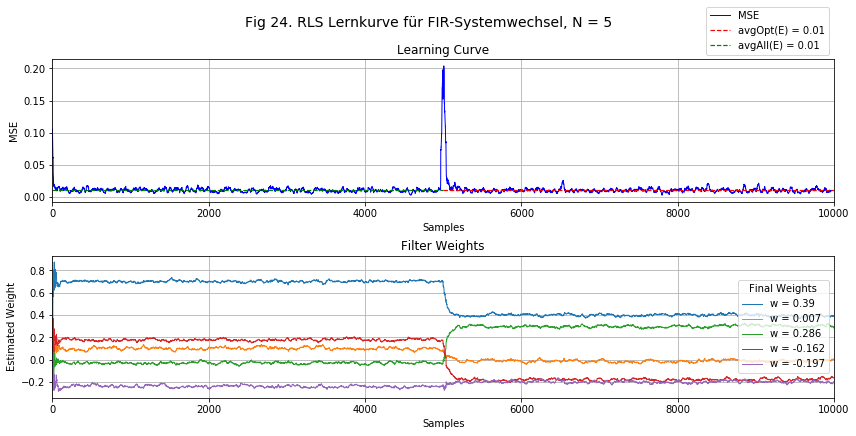

In [48]:
# FIR LMS/RLS study: System change
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10
plotStyle = 'lin'

# LMS, N = 5
N, mu, var = 5, 0.01, 0.01
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirXc, HfirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 23. LMS Lernkurve für FIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 5
N, var, forget = 5, 0.01, 0.02
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HfirXc, HfirDcn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 24. RLS Lernkurve für FIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 23 & 24.**
Ähnlich zu den Experimenten des IIR-Systemwechsels zeigt sich eine rasche Adaption der Filterkoeffizienten der LMS und RLS Algorithmen mit dem Resultat eines nur kurz ansteigenden MSE zum Zeitpunkt des Wechsels.

Durch Modifikation der Lernrate (LMS) und dem Vergessensfaktor (RLS) gilt es im Allgemeinen den Restfehler gegen die Geschwindigkeit der Adaption abzuwägen.

* LMS: N = 2, mu = 0.01, w = [ 0.36084213 -0.01751301]
       with AWGNS variance = 0.1, SNR = 6.71 dB
* RLS: N = 2, w = [0.39470641 0.02628262]
       with AWGNS variance = 0.1, SNR = 6.73 dB


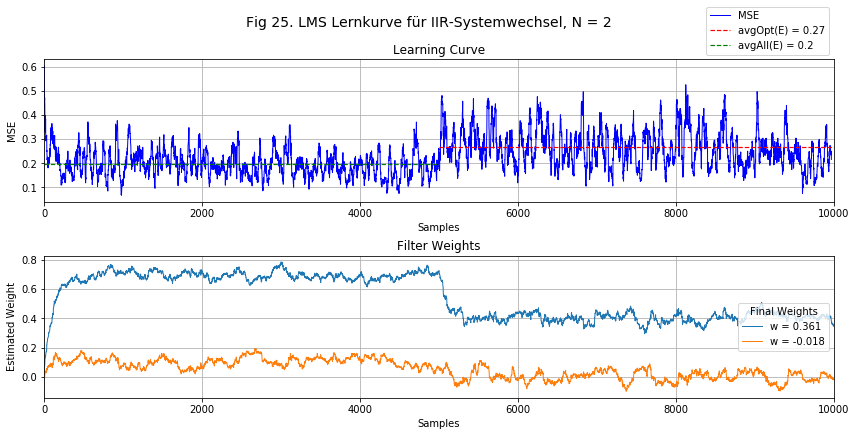

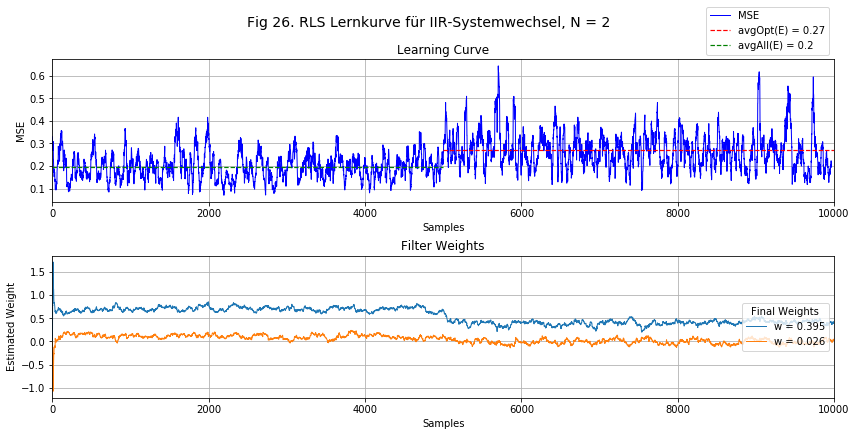

In [52]:
plotStyle = 'lin'

# LMS, N = 2
N, mu, var = 2, 0.01, 0.1
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirXc, HfirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 25. LMS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 2
N, var, forget = 2, 0.1, 0.02
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HfirXc, HfirDcn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 26. RLS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 25 & 26.**
Auch nach Reduzierung der verfügbaren Filtertaps auf $N = 2$ lässt sich das oben beschriebene Verhalten beobachten. Signifikant ist jedoch, das sich der Anstieg und weitere Verlauf des MSE (Lernkurve) nach dem Systemwechsel etwa gleich gravierend auf den LMS uns RLS auswirkt. Die Anzahl der Filtertaps mit $N = 2$ ist im Allgemeinen zu gering für das Problem gewählt.

#### Zu Aufgabe  3: Systemwechsel

Der LMS Algorithmus zeigt aufgrund seiner Adaptionsfreudigkeit und momentarischen Betrachtung des Zeitverlaufs eine gute Eigenung bei einem auftretenden Systemwechsel oder bei Änderung der Randbedingungen im Allgemeinen. Diese Robustheit gegenüber zeitlichen Änderungen des Systems und der Übertragungsstrecke bezeugen die Eignung für alle Fälle, die ein solches Verhalten erwarten lassen.

Der RLS Algorithmus zeigt zunächst ein schnelleres Adaptionsverhalt als der LMS. Durch den Systemwechsel ist die angesammelte Information für den RLS aber keine Hilfe mehr sondern wird zum Hindernis in der Adaption indem vergangene, redundante Information im Verhältnis zum aktuellen Zustand des Systems zu stark gewichtet werden. Dieses Verhalten macht den RLS Algorithmus anfällig für zeitliche Veränderungen des Systems und für allgemeine Veränderungen der Randbedingungen.

Durch Anpassung des Vergessemsfaktors, ähnlich zur Justierung der Learning Rate lassen sich auch für den RLS gute oder sogar bessere Ergebnisse erzielen. Wählt man den Forgetting Factor richtig, so stellt sich trotz Systemwechsel ein schneller Adaptionsverhalten ein. Lässt man den RLS jedoch zu schnell vergessen erhöht sich der Restfehler (MSE). Es gilt also diese beiden Verhalten abzuwägen. Geeignet für einen solche Optimierungsprozess der Hyperparameter Learning Rate und Forgetting Factor wäre eine nested cross validation.

## Aufgabe 4
Es soll nun ein Kernel Least Mean Squares (KLMS) Filter entworfen werden, dass eine Zeitreihenschätzung vornimmt. Zum Training wird eine Zeitreihe mit 500 Werten in der Datei Training.mat gegeben. Das trainierte Filter soll anschließend mit der Zeitreihe in Test.mat getestet werden. Der Kernel des KLMS darf aus der Familie der Exponentialfunktionen frei gewählt werden (Gauss, Laplace, o.ä.). Zum Vergleich der Schätzfähigkeit des KLMS sollen sowohl 5 vergangene als auch 10 vergangene Werte zur Schätzung herangezogen werden. Das gleiche Testszenario soll weiterhin mit einem LMS umgesetzt und für einen Vergleich zum KLMs herangezogen werden. Dazu sind Fehlerkurven auf den Testdaten zu erstellen sowie Erläuterungen zu den Einflüssen der jeweiligen Parameter der Filter anzugeben.

*** Importing files from directory: ./data/
* importing: System_FIR27.mat
* importing: System_IIR27.mat
* importing: Systemwechsel_FIR27.mat
* importing: Systemwechsel_IIR27.mat
* importing: Test.mat
* importing: Training.mat
*** 6 files imported
Traning mean:  0.8981513369893664
Training variance:  0.06541574384976366


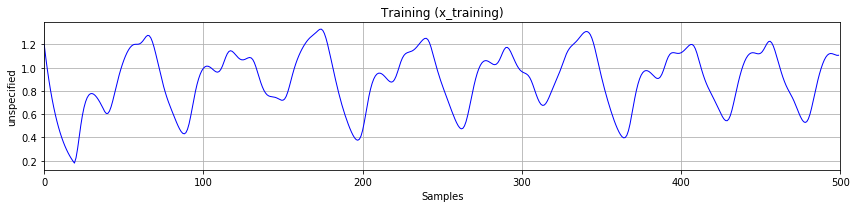

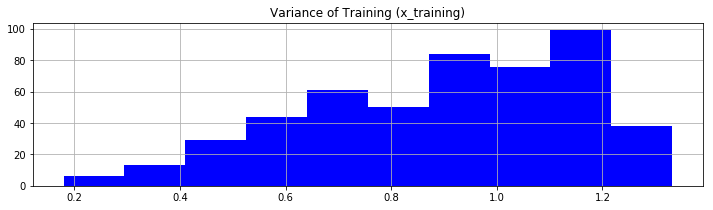

In [11]:
# imports
import algorithms as algo
import tools as ts
import kernels as ks
import numpy as np
import matplotlib.pyplot as plt

# load KLMS training and test data from dictionary
importMat, fileNames = ts.importmat('./data/')
x_training = importMat['Training']['x_training'].T
x_test = importMat['Test']['x_test'].T

# check Training
ts.plot(x_training,'Training (x_training)','lin',500)
ts.hist(x_training,'Variance of Training (x_training)')
print('Traning mean: ',np.mean(x_training))
print('Training variance: ',np.var(x_training))

# check Test
#ts.plot(x_test.T,'Training (x_training)','lin',500)
#ts.hist(x_test.T,'Variance of Training (x_training)')
#print('Test mean: ',np.mean(x_test))
#print('Test variance: ',np.var(x_test))

# No equal distribution - whitening? Center + Scale?
#x_training = x_training - np.mean(x_training)
#x_test = x_test - np.mean(x_test)


In [12]:
# KLMS
import algorithms as algo
import tools as ts

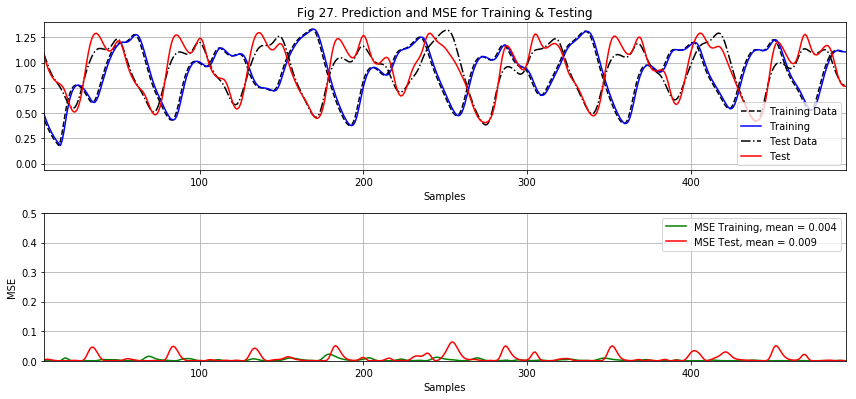

In [46]:
N = 5

# # # # # PLOT # # # # # #
# test / train data segment
start = 0
length = 500
end = start + length

traindata = x_training[:,start:end]
testdata = x_test[:,start:end]

# # # # # PLOT # # # # # #
plt.clf()
fig = plt.figure(figsize=(12, 6))

# Data vs Prediction
plt.subplot(211)

# Training
Kern = algo.klms(N, 'gauss', mu=1.0, sigma=1.0) # sig = 0.5 for N = 5
algo.Klearn(Kern, N, traindata)
E = Kern.errors # save error of training
plt.plot(traindata.T[N:],'k--',label='Training Data')
plt.plot(Kern.prediction,'b',label='Training')

# Testing
algo.Kpredict(Kern, N, testdata)
plt.plot(testdata.T[N:],'k-.',label='Test Data')
plt.plot(Kern.prediction,'r',label='Test')
plt.xlim([N,b-N])
plt.xlabel('Samples')
plt.grid(True)
plt.legend()
plt.title('Fig 27. Prediction and MSE for Training & Testing')

# MSE
trainMean = np.around(np.mean(E), decimals=3)
testMean = np.around(np.mean(Kern.errors), decimals=3)

plt.subplot(212)
plt.plot(E,'g',label='MSE Training (mean = '+str(trainMean)+')')
plt.plot(Kern.errors,'r',label='MSE Test (mean = '+str(testMean)+')')
plt.ylim([0, 0.5])
plt.xlim([N,b-N])
plt.xlabel('Samples')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

**Fig 27.** Im obigen Plot sind sowohl Training- als auch der Testdurchlauf für den KLMS mit $N = 5$ Taps. Mit der Lernrate $\mu = 1.0$ und einer Breite der Gauss-Kerne mit $\sigma = 1.0$ wurden hier die besten Ergebnisse erzielt.

Man bemerke die ansehnliche Adaption des Algorithmus im Trainingsdurchlauf mit weniger Fehler als im Trainingsdurchlauf. Ein solches Verhalten ist bei der Analyse eines Lernprozesses zu erwarten.

Erstaunlich ist, das sich das Verhalten bei der Zunahme von mehr Werten ($N > 5$) verschlechtert

## Fazit


### Literaturverzeichnis
[1] Moschytz, G., & Hofbauer, M. (2000). Adaptive Filter. Berlin ua: Springer.

[2] Liu, W., Principe, J. C., & Haykin, S. (2011). Kernel adaptive filtering: a comprehensive introduction (Vol. 57). John Wiley & Sons.